# Live Traffic Demo: 

This is a sample reference implementation to showcase object detection (car in this case) with single-shot detection (SSD) and Async API.
Async API improves the overall frame-rate of the application by not waiting for the inference to complete but continuing to do things on the host while inference accelerator is busy. 
Specifically, this code demonstrates two parallel inference requests by processing the current frame while the next input frame is being captured. This essentially hides the latency of frame capture.

## Overview of how it works
At start-up the sample application reads the equivalent of command line arguments and loads a network and image from the video input to the Inference Engine (IE) plugin. A job is submitted to an edge compute node with a hardware accelerator such as Intel® HD Graphics GPU, Intel® Movidius™ Neural Compute Stick 2, and Intel® Arria® 10 FPGA.
After the inference is completed, the output videos are appropriately stored in the /results directory, which can then be viewed within the Jupyter Notebook instance.

## Demonstration objectives
* Video as input is supported using **OpenCV**
* Inference performed on edge hardware (rather than on the development node hosting this Jupyter notebook)
* **OpenCV** provides the bounding boxes, labels and other information
* Visualization of the resulting bounding boxes
* Demonstrate the Async API in action


## Step 0: Set Up

### 0.1: Import dependencies

Run the below cell to import Python dependencies needed for displaying the results in this notebook
(tip: select the cell and use **Ctrl+enter** to run the cell)

In [1]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import os
import time
import sys                                     
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent.parent))
from demoTools.demoutils import *

## Step 1: Using Intel® Distribution of OpenVINO™ toolkit

First, let's try running inference on a single image to see how the Intel® Distribution of OpenVINO™ toolkit works.
We will be using Intel® Distribution of OpenVINO™ toolkit Inference Engine (IE) to locate vehicles on the road.
There are five steps involved in this task:

1. Create an Intermediate Representation (IR) Model using the Model Optimizer by Intel
2. Choose a device and create IEPlugin for the device
3. Read the IRModel using IENetwork
4. Load the IENetwork into the Plugin
5. Run inference.

### 1.1 Creating IR Model

The Model Optimizer creates Intermediate Representation (IR) models that are optimized for different end-point target devices.
These models can be created from existing DNN models from popular frameworks (e.g. Caffe*, TF) using the Model Optimizer. 
The Intel® Distribution of OpenVINO™ toolkit includes a utility script `model_downloader.py` that you can use to download some common models. Run the following cell to see the models available through `model_downloader.py`

In [ ]:
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --print_all

**Note** the '!' is a special Jupyter Notebook command that allows you to run shell commands as if you are in a commannd line. So the above command will work straight out of the box on in a terminal (with '!' removed).

Some of these downloaded models are already in the IR format, while others will require the model optimizer. In this demo, we will be using the **person-vehicle-bike-detection-crossroad** model, which is already in IR format. This model can be downloaded with the following command.

In [2]:
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name person-vehicle-bike-detection-crossroad-0078 -o models

################|| Downloading models ||################

========== Downloading models/intel/person-vehicle-bike-detection-crossroad-0078/FP32/person-vehicle-bike-detection-crossroad-0078.xml
... 100%, 165 KB, 2548 KB/s, 0 seconds passed

========== Downloading models/intel/person-vehicle-bike-detection-crossroad-0078/FP32/person-vehicle-bike-detection-crossroad-0078.bin
... 100%, 4603 KB, 27948 KB/s, 0 seconds passed

========== Downloading models/intel/person-vehicle-bike-detection-crossroad-0078/FP16/person-vehicle-bike-detection-crossroad-0078.xml
... 100%, 165 KB, 5373 KB/s, 0 seconds passed

========== Downloading models/intel/person-vehicle-bike-detection-crossroad-0078/FP16/person-vehicle-bike-detection-crossroad-0078.bin
... 100%, 2301 KB, 30087 KB/s, 0 seconds passed

========== Downloading models/intel/person-vehicle-bike-detection-crossroad-0078/INT8/person-vehicle-bike-detection-crossroad-0078.xml
... 100%, 20364 KB, 8692 KB/s, 2 seconds passed

========== Downloading mod

The input arguments are as follows:
* --name : name of the model you want to download. It should be one of the models listed in the previous cell
* -o : output directory. If this directory does not exist, it will be created for you.

There are more arguments to this script and you can get the full list using the `-h` option.


With the `-o` option set as above, this command downloads the model in the directory `models`, with the model files (.xml and .bin) located at `models/Security/object_detection/crossroad/0078/dldt/`



## Step 2 : Inference on a video

The inference code is already implemented in 
<a href="live_traffic_detection.py">live_traffic_detection.py</a>.

The Python code takes in command line arguments for video, model etc.

**Command line arguments options and how they are interpreted in the application source code**

```
python3 live_traffic_detection.py  -m ${MODELPATH} \
                                   -i ${INPUT_ADDR} \
                                   -o ${OUTPUT_DIR} \
                                   -d ${DEVICE} \
                                   -c 300 \
                                   -l /opt/intel/computer_vision_sdk/deployment_tools/inference_engine/samples/build/intel64/Release/lib/libcpu_extension.so
```

##### The description of the arguments used in the argument parser is the command line executable equivalent.
* -m location of the pre-trained IR model which has been pre-processed using the **model optimizer**
   There is automated support built in this argument to support both FP32 and FP16 models targeting different hardware
   (**Note** we are using mobilenet-ssd in this example. However, Intel® Distribution of OpenVINO™ toolkit Inference Engine is compatible with other neural network architectures such as AlexNet*, GoogleNet*, MxNet* etc.,)    

* -i location of the input video stream 
* -o location where the output file with inference needs to be stored. (results/)
* -d Type of Hardware Acceleration (CPU, GPU, MYRIAD, HDDL or HETERO:FPGA,CPU)
* -c Maximum number of frames to processes
* -l Absolute path to the shared library and is currently optimized for core/xeon (extension/libcpu_extension.so )


### 2.1 Creating job file

All the code up to this point has been run within the Jupyter Notebook instance running on a development node based on an Intel® Xeon® Scalable processor, where the Notebook is allocated a single core. 
To run inference on the entire video, we need more compute power.
We will run the workload on several edge compute nodes represented in the IoT DevCloud. We will send work to the edge compute nodes by submitting the corresponding non-interactive jobs into a queue. For each job, we will specify the type of the edge compute server that must be allocated for the job.

The job file is written in Bash, and will be executed directly on the edge compute node.
For this example, we have written the job file for you in the notebook.
Run the following cell to write this in to the file "traffic_detection_job.sh"

In [3]:
%%writefile traffic_detection_job.sh

# The default path for the job is your home directory, so we change directory to where the files are.
cd $PBS_O_WORKDIR

# Traffic detection script writes output to a file inside a directory. We make sure that this directory exists.
# The output directory is the first argument of the bash script
OUTPUT_DIR=$1
DEVICE=$2
FP_MODEL=$3
INPUT_ADDR=$4

if [ "$DEVICE" = "HETERO:FPGA,CPU" ]; then
  # Environment variables and compilation for edge compute nodes with FPGAs
  source /opt/fpga_support_files/setup_env.sh
  aocl program acl0 /opt/intel/computer_vision_sdk/bitstreams/a10_vision_design_bitstreams/5-0_PL1_FP16_ResNet_TinyYolo_ELU.aocx
fi

# Running the traffic detection code
SAMPLEPATH=${PBS_O_WORKDIR}
if [ "$FP_MODEL" = "FP32" ]; then
  MODELPATH=${SAMPLEPATH}/models/intel/person-vehicle-bike-detection-crossroad-0078/FP32/person-vehicle-bike-detection-crossroad-0078.xml
else
  MODELPATH=${SAMPLEPATH}/models/intel/person-vehicle-bike-detection-crossroad-0078/FP16/person-vehicle-bike-detection-crossroad-0078.xml
fi

python3 live_traffic_detection.py  -m ${MODELPATH} \
                                   -i ${INPUT_ADDR} \
                                   -o ${OUTPUT_DIR} \
                                   -d ${DEVICE} \
                                   -c 300 \
                                   -l /opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_sse4.so


Overwriting traffic_detection_job.sh


After running the traffic detection code, we have a list of bounding boxes for the detected objects. This may be the end of the object detection workflow some applications that just need the locations, sizes and types of the detected objects. However, if a human needs to view the output video stream, we may want to produce an output video where the bounding boxes are drawn on top of the detected objects.

We treat video rendering as a separate task, and is timed separately.

### 2.2 Understand how jobs are submitted into the queue

Now that we have the job script, we can submit the jobs to edge compute nodes. In the IoT DevCloud, you can do this using the `qsub` command.
We can submit traffic_detection_job to several different types of edge compute nodes simultaneously or just one node at a time.

There are three options of `qsub` command that we use for this:
- `-l` : this option lets us select the number and the type of nodes using `nodes={node_count}:{property}`. 
- `-F` : this option lets us send arguments to the bash script. 
- `-N` : this option lets use name the job so that it is easier to distinguish between them.

The `-F` flag is used to pass in arguments to the job script.
The [traffic_detection_job.sh](traffic_detection_job.sh) takes in 4 arguments:
1. the path to the directory for the output video and performance stats
2. targeted device (e.g. CPU, GPU, MYRIAD, HDDL or HETERO:FPGA,CPU)
3. the floating precision to use for inference
4. the path to the input video

The job scheduler will use the contents of `-F` flag as the argument to the job script.

If you are curious to see the available types of nodes on the IoT DevCloud, run the following optional cell.

In [ ]:
!pbsnodes | grep compnode | awk '{print $3}' | sort | uniq -c

Here, the properties describe the node, and number on the left is the number of available nodes of that architecture.

### 2.3 Job queue submission

Each of the 4 cells below will submit a job to different edge compute nodes.
The output of the cell is the `JobID` of your job, which you can use to track progress of a job.

**Note** You can submit all 5 jobs at once or follow one at a time. 

After submission, they will go into a queue and run as soon as the requested compute resources become available. 
(tip: **shift+enter** will run the cell and automatically move you to the next cell. So you can hit **shift+enter** multiple times to quickly run multiple cells)


For this workload, we will be using a video from a [live traffic camera hosted by Calfornia DOT](http://www.dot.ca.gov/video/). We have selected a good stream for your convenience, but feel free to try the other videos hosted (legally) there or elsewhere by changing the below line.
Also, note that depending on the time of day in California, USA, there may not be cars in the video. 

In [4]:
os.environ["VIDEO"] = "rtmp://wzmedia.dot.ca.gov/D4/S880_at_JCT_84.stream"
#os.environ["VIDEO"] = "/data/reference-sample-data/object-detection-python/cars_1900.mp4"

#### Submitting to an edge compute node with an Intel® CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core™ i5-6500TE processor</a>. The inference workload will run the CPU.

In [5]:
#Submit job to the queue
job_id_core = !qsub traffic_detection_job.sh -l nodes=1:kaby-lake -F "results/ CPU FP32 $VIDEO" -N traf_det_core
print(job_id_core[0]) 
#Progress indicators
if job_id_core:
    progressIndicator('results/', 'i_progress_'+job_id_core[0]+'.txt', "Inference", 0, 100)
    progressIndicator('results/', 'v_progress_'+job_id_core[0]+'.txt', "Rendering", 0, 100)
else:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
    print("Error in job submission.")

922.v-qsvr-1.devcloud-edge


In [ ]:
#!python live_traffic_detection.py -m models/intel/person-vehicle-bike-detection-crossroad-0078/FP32/person-vehicle-bike-detection-crossroad-0078.xml -i /home/ieisw/Desktop/car-detection.mp4 -l /opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_sse4.so -d HDDL -pt 0.5 -o results/hddlr/ -c 200

In [ ]:
#!python live_traffic_detection.py -m models/intel/person-vehicle-bike-detection-crossroad-0078/FP32/person-vehicle-bike-detection-crossroad-0078.xml -i /home/ieisw/Desktop/car-detection.mp4 -l /opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_sse4.so -d CPU -pt 0.5 -o results/hddlr/ -c 200

In [ ]:
#!python live_traffic_detection.py -m models/intel/person-vehicle-bike-detection-crossroad-0078/FP32/person-vehicle-bike-detection-crossroad-0078.xml -i /home/ieisw/Desktop/car-detection.mp4 -l /opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_sse4.so -d GPU -pt 0.5 -o results/hddlr/ -c 200

In [ ]:
#!python live_traffic_detection.py -m models/intel/person-vehicle-bike-detection-crossroad-0078/FP32/person-vehicle-bike-detection-crossroad-0078.xml -i /home/ieisw/Desktop/car-detection.mp4 -l /opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_sse4.so -d MYRIAD -pt 0.5 -o results/hddlr/ -c 200

#### Submitting to an edge compute node with Intel® Xeon® CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88178/Intel-Xeon-Processor-E3-1268L-v5-8M-Cache-2-40-GHz-">Intel® 
    Xeon® Processor E3-1268L v5</a>. The inference workload will run on the CPU.

In [6]:
#Submit job to the queue
job_id_xeon = !qsub traffic_detection_job.sh -l nodes=1:skylake -F "results/ CPU FP32 $VIDEO" -N traf_det_xeon 
print(job_id_xeon[0]) 
#Progress indicators
if job_id_xeon:
    progressIndicator('results/', 'i_progress_'+job_id_xeon[0]+'.txt', "Inference", 0, 100)
    progressIndicator('results/', 'v_progress_'+job_id_xeon[0]+'.txt', "Rendering", 0, 100)

923.v-qsvr-1.devcloud-edge


In [ ]:
!ls results
videoHTML('Output video', ['results/output_739.v-qsvr-1.devcloud-edge.mp4'])

#### Submitting to an edge compute node with Intel® Core CPU and using the onboard Intel® GPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core i5-6500TE</a>. The inference workload will run on the Intel® HD Graphics 530 card integrated with the CPU.

In [7]:
#Submit job to the queue
job_id_gpu = !qsub traffic_detection_job.sh -l nodes=1:intel-hd-p530 -F "results/ GPU FP32 $VIDEO" -N traf_det_gpu 
print(job_id_gpu[0]) 
#Progress indicators
if job_id_gpu:
    progressIndicator('results/', 'i_progress_'+job_id_gpu[0]+'.txt', "Inference", 0, 100)
    progressIndicator('results/', 'v_progress_'+job_id_gpu[0]+'.txt', "Rendering", 0, 100)

924.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with Intel® NCS 2 (Neural Compute Stick 2)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload will run on an <a 
    href="https://software.intel.com/en-us/neural-compute-stick">Intel Neural Compute Stick 2</a> installed in this  node.

In [8]:
#Submit job to the queue
job_id_ncs2 = !qsub traffic_detection_job.sh -l nodes=1:intel-ncs2 -F "results/ MYRIAD FP16 $VIDEO" -N traf_det_ncs2
print(job_id_ncs2[0]) 
#Progress indicators
if job_id_ncs2:
    progressIndicator('results/', 'i_progress_'+job_id_ncs2[0]+'.txt', "Inference", 0, 100)
    progressIndicator('results/', 'v_progress_'+job_id_ncs2[0]+'.txt', "Rendering", 0, 100)

925.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with UP Squared Grove IoT Development Kit (UP2)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/up-squared-grove-dev-kit">UP Squared Grove IoT Development Kit</a> edge node with an <a 
    href="https://ark.intel.com/products/96488/Intel-Atom-x7-E3950-Processor-2M-Cache-up-to-2-00-GHz-">Intel® Atom® x7-E3950 Processor</a>. The inference  workload will run on the integrated Intel® HD Graphics 505 card.

In [ ]:
#Submit job to the queue
job_id_up2 = !qsub traffic_detection_job.sh -l nodes=1:up-squared -F "results/ GPU FP32 $VIDEO" -N traf_det_up2
print(job_id_up2[0]) 
#Progress indicators
if job_id_up2:
    progressIndicator('results/', 'i_progress_'+job_id_up2[0]+'.txt', "Inference", 0, 100)
    progressIndicator('results/', 'v_progress_'+job_id_up2[0]+'.txt', "Rendering", 0, 100)

#### HDDL-R

In [ ]:
#Submit job to the queue
job_id_hddlr = !qsub traffic_detection_job.sh -l nodes=1:hddl-r -F "results/ HDDL FP16 $VIDEO" -N traf_det_hddlr
print(job_id_hddlr[0]) 
#Progress indicators
if job_id_hddlr:
    progressIndicator('results/', 'i_progress_'+job_id_hddlr[0]+'.txt', "Inference", 0, 100)
    progressIndicator('results/', 'v_progress_'+job_id_hddlr[0]+'.txt', "Rendering", 0, 100)

### 2.4 Check if the jobs are done

To check on the jobs that were submitted, use the `qstat` command.

We have created a custom Jupyter widget  to get live qstat update.
Run the following cell to bring it up. 

In [ ]:
liveQstat()

You should see the jobs you have submitted (referenced by `Job ID` that gets displayed right after you submit the job in step 2.3).
There should also be an extra job in the queue "jupyterhub": this job runs your current Jupyter Notebook session.

The 'S' column shows the current status. 
- If it is in Q state, it is in the queue waiting for available resources. 
- If it is in R state, it is running. 
- If the job is no longer listed, it means it is completed.

**Note**: Time spent in the queue depends on the number of users accessing the edge nodes. Once these jobs begin to run, they should take from 1 to 5 minutes to complete. 

***Wait!***

Please wait for the inference jobs and video rendering complete before proceeding to the next step.

## Step 3: View Results

Once the jobs are completed, the queue system outputs the stdout and stderr streams of each job into files with names of the form

`traf_det_{type}.o{JobID}`

`traf_det_{type}.e{JobID}`

(here, traf_det_{type} corresponds to the `-N` option of qsub).

However, for this case, we may be more interested in the output video files. They are stored in mp4 format inside the `results/` directory.
We wrote a short utility script that will display these videos with in the notebook.
Run the cells below to display them.
See `demoutils.py` if you are interested in understanding further how the results are displayed in notebook.


In [9]:
videoHTML('IEI Tank (Intel Core CPU)', 
          ['results/output_'+job_id_core[0]+'.mp4'], 
          'results/stats_'+job_id_core[0]+'.txt')

In [10]:
videoHTML('IEI Tank Xeon (Intel Xeon CPU)',
          ['results/output_'+job_id_xeon[0]+'.mp4'],
          'results/stats_'+job_id_xeon[0]+'.txt')

In [11]:
videoHTML('IEI Intel GPU (Intel Core + Onboard GPU)', 
          ['results/output_'+job_id_gpu[0]+'.mp4'],
          'results/stats_'+job_id_gpu[0]+'.txt')

In [12]:
videoHTML('IEI Tank + Intel CPU + Intel NCS2',
          ['results/output_'+job_id_ncs2[0]+'.mp4'],
          'results/stats_'+job_id_ncs2[0]+'.txt')

In [ ]:
videoHTML('UP Squared Grove IoT Development Kit (UP2)',
          ['results/output_'+job_id_up2[0]+'.mp4'],
          'results/stats_'+job_id_up2[0]+'.txt')

## Step 4: Assess Performance

The running time of each inference task is recorded in `results/stats_job_id_{ARCH}.txt`, where the subdirectory name corresponds to the architecture of the target edge compute node. Run the cell below to plot the results of all jobs side-by-side. Lower values mean better performance. Keep in mind that some architectures are optimized for the highest performance, others for low power or other metrics.

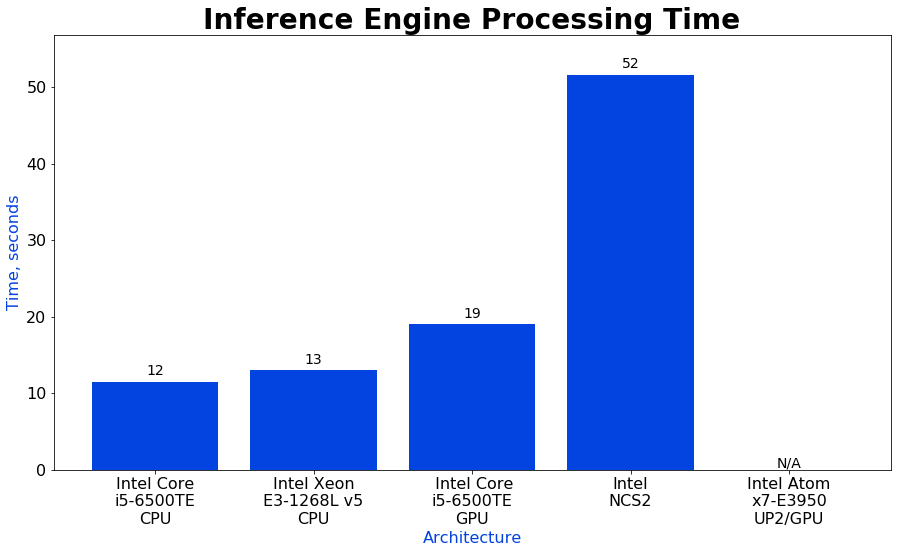

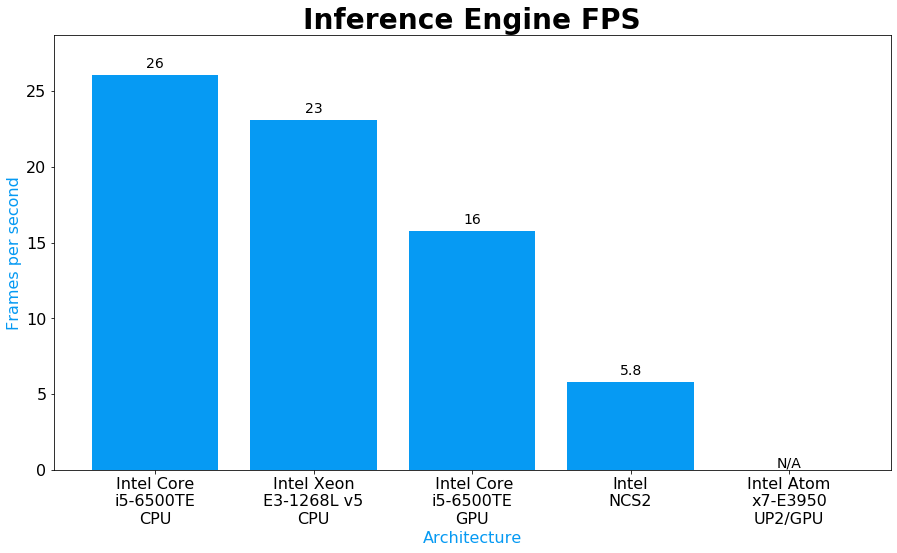

In [13]:
arch_list = [('core', 'Intel Core\ni5-6500TE\nCPU'),
             ('xeon', 'Intel Xeon\nE3-1268L v5\nCPU'),
             ('gpu', ' Intel Core\ni5-6500TE\nGPU'),
             ('ncs2', 'Intel\nNCS2'),
             ('up2', 'Intel Atom\nx7-E3950\nUP2/GPU')]

stats_list = []
for arch, a_name in arch_list:
    if 'job_id_'+arch in vars():
        stats_list.append(('results/stats_'+vars()['job_id_'+arch][0]+'.txt', a_name))
    else:
        stats_list.append(('placeholder'+arch, a_name))

summaryPlot(stats_list, 'Architecture', 'Time, seconds', 'Inference Engine Processing Time', 'time' )

summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Inference Engine FPS', 'fps' )